In [ ]:
!pip install scikit-learn==0.23.1
!pip install imbalanced-learn==0.7.0
!pip install autocorrect

     |████████████████████████████████| 6.8 MB 15.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 167 kB 40.9 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3
     |████████████████████████████████| 622 kB 21.8 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.5.0-py3-none-any.whl size=621851 sha256=9a4afd823e9fac9c7127e9d19c4c344ab1828c4af76db55bb2e120da6d6044ce
  Stored in directory: /root/.cache/pip/wheels/3d/8e/bd/f6fd900a056a031bf710a00bca338d86f43b83f0c25ab5242f
Successfully built autocorrect


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from autocorrect import Speller
import re
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import rmsprop_v2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
df = pd.read_csv('/content/cust_data_train.csv', encoding = 'unicode_escape', engine ='python')

In [ ]:
df.columns = (df.columns.str.strip().str.upper().str.replace(' ', '_'))

In [ ]:
df.columns

Index(['PRODUCT_ID', 'CUSTOMER_AGE', 'CUSTOMER_FEEDBACK', 'CUSTOMER_CATEGORY'], dtype='object')

In [ ]:
#Checking if any customer fedback is null
df['CUSTOMER_FEEDBACK'].isna().sum()

#since we have two features age and feedback. will not be deleting the reviews if null.

686

In [ ]:
#Droping the rows if age and cutomer FeedBack has null
df.dropna(axis=0, subset=['CUSTOMER_AGE', 'CUSTOMER_FEEDBACK'], how='all', inplace=True)

In [ ]:
df.dtypes

PRODUCT_ID            int64
CUSTOMER_AGE          int64
CUSTOMER_FEEDBACK    object
CUSTOMER_CATEGORY    object
dtype: object

In [ ]:
# Checking records count for each category.
df['CUSTOMER_CATEGORY'].value_counts()
#Since Detractor has imbalanced records so need to upsamble the data points for detractor.

In [ ]:
le = LabelEncoder()
df['CUSTOMER_CATEGORY'] = le.fit_transform(df['CUSTOMER_CATEGORY'].values)

In [ ]:
df['CUSTOMER_AGE'].corr(df['CUSTOMER_CATEGORY'])

0.027463268327204138

                   CUSTOMER_AGE  CUSTOMER_CATEGORY
CUSTOMER_AGE           1.000000           0.027463
CUSTOMER_CATEGORY      0.027463           1.000000


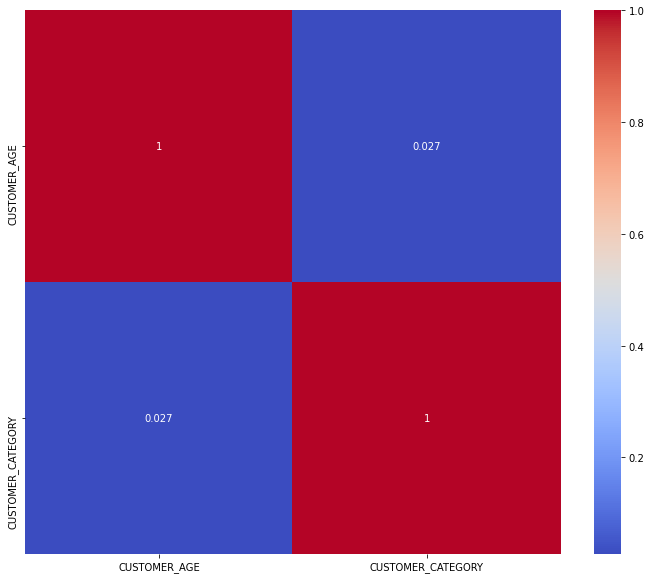

In [ ]:
# Correlation heatmap
corr = df[['CUSTOMER_AGE','CUSTOMER_CATEGORY']].corr() 
print(corr)
plt.figure(figsize=(12, 10))

sns.heatmap(corr, annot = True, fmt='.2g',cmap= 'coolwarm')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


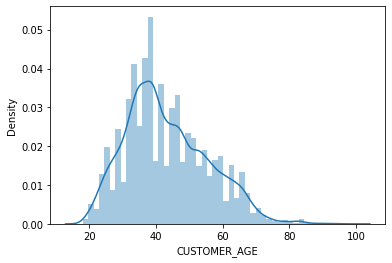

In [ ]:
sns.distplot(df['CUSTOMER_AGE'])
plt.show()

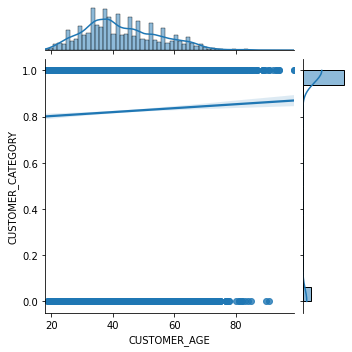

In [ ]:
# joint plots for age and feedback
cols = ["CUSTOMER_AGE"]
for c in cols:
    sns.jointplot(x=c, y="CUSTOMER_CATEGORY", data=df, kind = 'reg', height = 5)
plt.show()

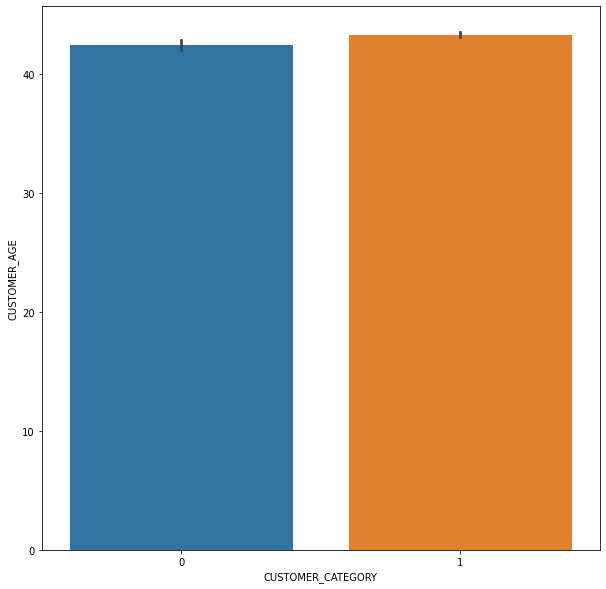

In [ ]:
# bar plots 
fig, axes = plt.subplots(figsize=(10, 10))
sns.barplot(x="CUSTOMER_CATEGORY", y="CUSTOMER_AGE", data=df)

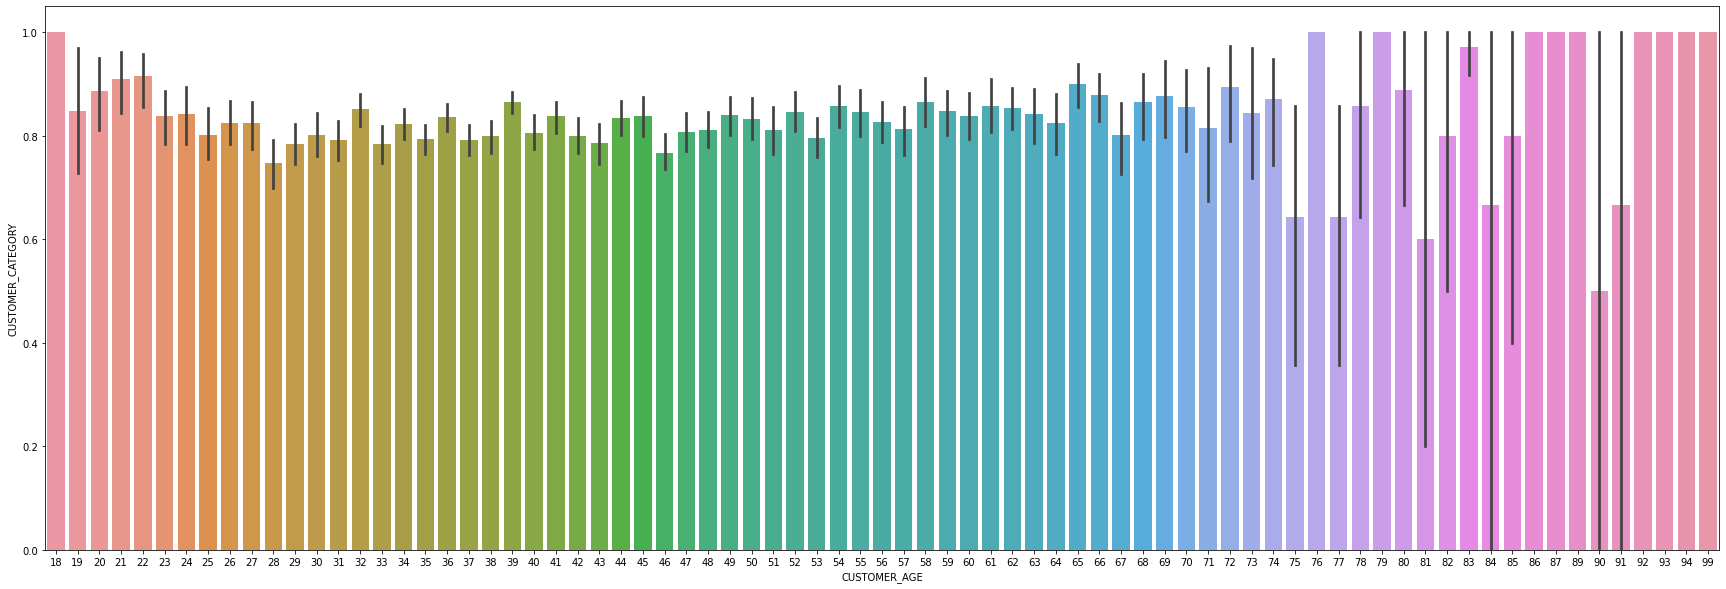

In [ ]:
# bar plots 
fig, axes = plt.subplots(figsize=(30, 10))
sns.barplot(x="CUSTOMER_AGE", y="CUSTOMER_CATEGORY", data=df)

After seeing the correlation matrix age and feedback and bar plot its has very less correlation. still we can keep it as feature for prediction.

In [ ]:
df['CUSTOMER_FEEDBACK'] = df['CUSTOMER_FEEDBACK'].astype(str)

In [ ]:
df.head()

,PRODUCT_ID,CUSTOMER_AGE,CUSTOMER_FEEDBACK,CUSTOMER_CATEGORY
0,865,44,I strongly disagree with the previous reviewer...,1
1,1068,44,Bummed out.. this is super cheaply made and ve...,0
2,974,67,The colors on this jacket are a murky blue wit...,0
3,1104,66,I love the style the lightness and the fit ......,0
4,820,32,"I am very petite (size 00, xxs) and i got the ...",1


In [ ]:
stop_words = set(STOPWORDS)
print(len(stop_words))
[stop_words.add(x) for x in nltk.corpus.stopwords.words('english')]
print(len(stop_words))
stop_words_after_analyzed = {'dress', 'top', 'fit', 'size', 'look', 'one', 'love', 'small', 'color','fabric', 'cute', 'great', 'ordered', 'really' ,'this', 'wear'}
stop_words = stop_words.union(stop_words_after_analyzed)
print(type(stop_words))
print(len(stop_words))

190
225
<class 'set'>
240


In [ ]:
WORD = re.compile(r'\w+')
spell = Speller(lang="en")

def reTokenize(doc):
  tokens = WORD.findall(doc)
  return tokens

def text_process(text):
  rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''},  # remove spaces at the beginning
        {r'[^A-Za-z0-9 ]+': u''} #Removing special charactors
    ]
    
  for rule in rules:
    for (k, v) in rule.items():
        regex = re.compile(k)
        text = regex.sub(v, text)
  text = text.rstrip()
  #print(text)
  stemmer = WordNetLemmatizer()
  text = [char for char in text if char not in string.punctuation]
  text = ''.join([i for i in text if not i.isdigit()])
  text = [word.lower() for word in text.split() if word not in stop_words]
  #text = [' '.join([spell(w).lower() for w in reTokenize(doc)]) for doc in text if doc not in set(nltk.corpus.words.words())]
  text = [stemmer.lemmatize(word) for word in text]  
  text = [i for i in text if len(i) >2] # Removing the small words   
  #print(stemed)
  return ' '.join(text)

In [ ]:
print(text_process('I am mahesh'))

mahesh


There are 2307721 words in the combination of promoter Feedback.
There are 528524 words in the combination of detractor Feedback.


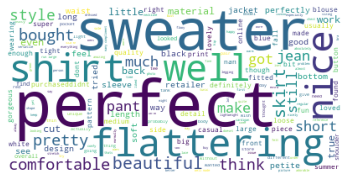

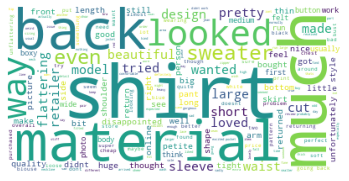

In [ ]:
promoter_df = df[df['CUSTOMER_CATEGORY'] == 1]['CUSTOMER_FEEDBACK']
detractor_df = df[df['CUSTOMER_CATEGORY'] == 0]['CUSTOMER_FEEDBACK']
detractor_df = detractor_df.apply(text_process)
promoter_df = promoter_df.apply(text_process)
promoter_text = ' '.join(promoter_df)
detractor_text = ' '.join(detractor_df)
print ("There are {} words in the combination of promoter Feedback.".format(len(promoter_text)))
print ("There are {} words in the combination of detractor Feedback.".format(len(detractor_text)))

promoter_cloud = WordCloud(stopwords=stop_words, background_color="white").generate(promoter_text)
detractor_cloud = WordCloud(stopwords=stop_words, background_color="white").generate(detractor_text)
# Generate plot
plt.imshow(promoter_cloud)
plt.axis("off")
plt.show()

plt.imshow(detractor_cloud)
plt.axis("off")
plt.show()

346810
78983
['back' 'beautiful' 'flattering' 'large' 'look' 'sweater' 'this']


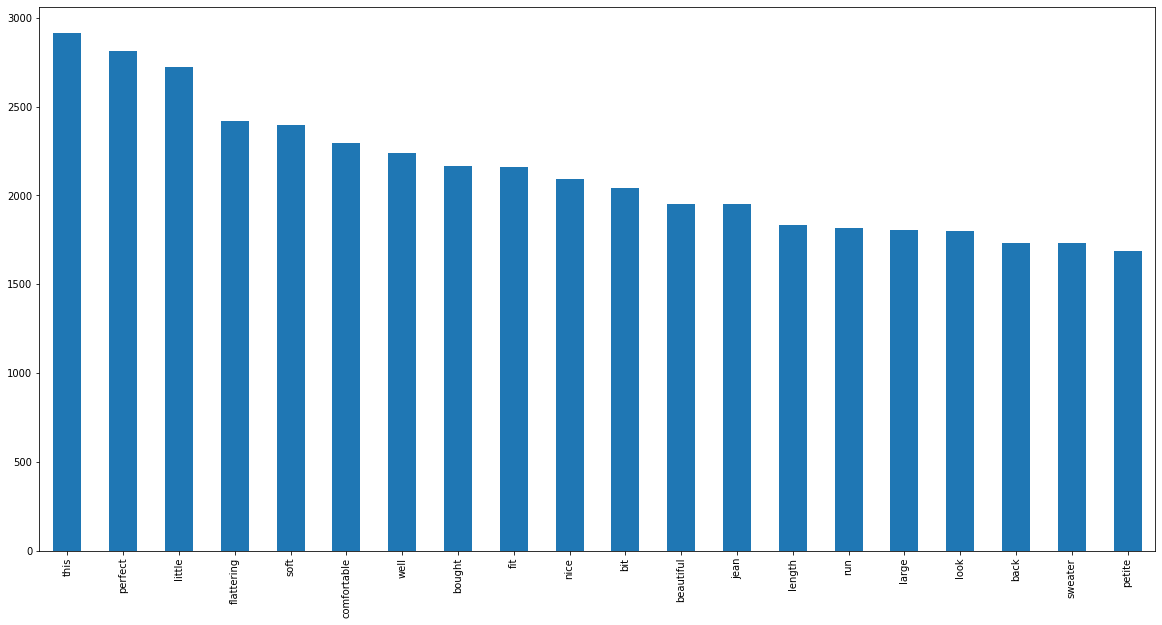

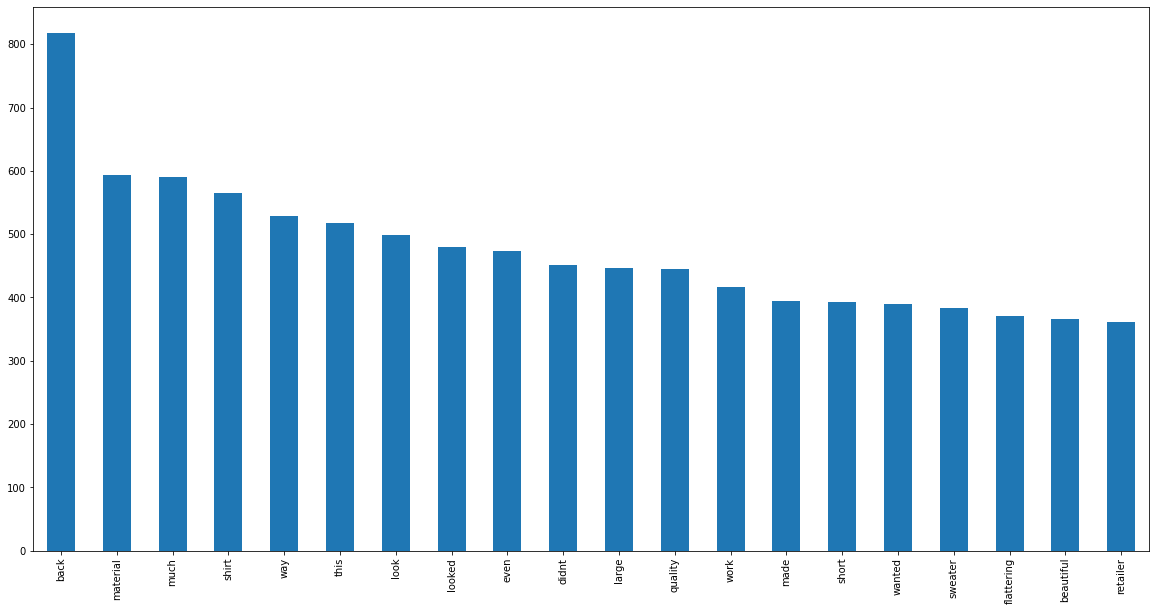

In [ ]:
splited_data = [promoter_text, detractor_text]

promoter_top_words = pd.Series(''.join([i for i in promoter_text]).split()).value_counts()
detractor_top_words = pd.Series(''.join([i for i in detractor_text]).split()).value_counts()

print(sum(promoter_top_words))
print(sum(detractor_top_words))

prom = promoter_top_words.head(20).index.values
detr = detractor_top_words.head(20).index.values

inter = np.intersect1d(prom, detr)

print(inter)

for item in range(2):
  plt.figure(figsize=(20, 10))
  pd.Series(''.join([i for i in splited_data[item]]).split()).value_counts().head(20).plot(kind='bar')
  plt.show()

Here we can clearly observe that there is a word 'dress', 'top', 'fit', 'size', 'look', 'one', 'love', 'small', 'color', 'wear' which is common in both and having highest frequency So, will be remove the these word from our corpus for a better performance.

In [ ]:
def text_process_tfidf(text):
  WORD = re.compile(r'\w+')
spell = Speller(lang="en")

def reTokenize(doc):
  tokens = WORD.findall(doc)
  return tokens

def text_process_tfidf(text):
  rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''},  # remove spaces at the beginning
        {r'[^A-Za-z0-9 ]+': u''} #Removing special charactors
    ]
    
  for rule in rules:
    for (k, v) in rule.items():
        regex = re.compile(k)
        text = regex.sub(v, text)
  text = text.rstrip()
  #print(text)
  stemmer = WordNetLemmatizer()
  text = [char for char in text if char not in string.punctuation]
  text = ''.join([i for i in text if not i.isdigit()])
  text = [word.lower() for word in text.split() if word not in stop_words]
  #text = [' '.join([spell(w).lower() for w in reTokenize(doc)]) for doc in text if doc not in set(nltk.corpus.words.words())]
  text = [stemmer.lemmatize(word) for word in text]  
  text = [i for i in text if len(i) >2] # Removing the small words   
  #print(stemed)
  return text

In [ ]:
# params = {'tfidf__use_idf': True, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__analyzer' : text_process}  # found in GridSearchCV
# text_pipe = Pipeline([
#   #  ("selector", ColumnTransformer([("selector", "passthrough", 'CUSTOMER_FEEDBACK')], remainder="drop")),
#     ('tfidf', TfidfVectorizer()),
#     # Down sampling given very low accuracy so using over sampling
#     #('sampling', RandomOverSampler(random_state=42)),
#     # ('scale', StandardScaler()),
# ])
# text_pipe.set_params(**params)

number_pipe = Pipeline([
   # ("selector", ColumnTransformer([("selector", "passthrough", 'CUSTOMER_AGE')], remainder="drop")),
    ('scale', MinMaxScaler())])


In [ ]:
df['CUSTOMER_AGE'] =  number_pipe.fit_transform(df[['CUSTOMER_AGE']])

In [ ]:
df.head()

,PRODUCT_ID,CUSTOMER_AGE,CUSTOMER_FEEDBACK,CUSTOMER_CATEGORY
0,865,0.320988,I strongly disagree with the previous reviewer...,1
1,1068,0.320988,Bummed out.. this is super cheaply made and ve...,0
2,974,0.604938,The colors on this jacket are a murky blue wit...,0
3,1104,0.592593,I love the style the lightness and the fit ......,0
4,820,0.172840,"I am very petite (size 00, xxs) and i got the ...",1


In [ ]:
vector = TfidfVectorizer(analyzer=text_process_tfidf, ngram_range=(2, 2), min_df=5, max_features=7000)
tfidf_dense = vector.fit_transform(df['CUSTOMER_FEEDBACK']).todense()
new_cols = vector.get_feature_names()

# removing the CUSTOMER_FEEDBACK column as the word 'CUSTOMER_FEEDBACK' may exist in the words and will get an error
df_temp = df.drop('CUSTOMER_FEEDBACK',axis=1)
# join the tfidf values to the existing dataframe
df_final = df_temp.join(pd.DataFrame(tfidf_dense, columns=new_cols))
#df_tfidf = pd.DataFrame(tfidf_dense, columns=new_cols)
df_final

,PRODUCT_ID,CUSTOMER_AGE,CUSTOMER_CATEGORY,abdomen,ability,able,absolute,absolutely,abt,abundance,accent,accentuate,accentuated,accentuates,accentuating,acceptable,accessorize,accessory,accident,accidentally,accommodate,accommodates,according,accurate,accurately,achieve,across,acrylic,act,active,activity,actual,actuality,actually,add,added,adding,addition,additional,additionally,...,writing,written,wrong,wrote,xsmall,xsp,xspetite,xssm,xxsp,yarn,yay,yeah,year,yearold,yearround,yellow,yep,yes,yesterday,yet,yikes,yoga,yoke,you,youd,youll,young,younger,youre,youthful,youve,yummy,zero,zip,zipped,zipper,zippered,zipping,zone,zoom
0,865,0.320988,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1068,0.320988,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,974,0.604938,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1104,0.592593,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,820,0.172840,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18783,949,0.641975,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18784,1081,0.481481,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18785,927,0.123457,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18786,1011,0.172840,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2000)
#tfidf_dense_pca = pca.fit_transform(df_tfidf)

In [ ]:
#pca.components_.T.shape

In [ ]:
X = df_final.loc[:, df_final.columns != 'CUSTOMER_CATEGORY']
Y = df_final['CUSTOMER_CATEGORY']

In [ ]:
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(X, Y)

In [ ]:
# Before 
print(df['CUSTOMER_CATEGORY'].value_counts())
# Checking records count for each category after upsample.
print(y_train.value_counts())
print(x_train.shape)
print(y_train.shape)

1    15451
0     3337
Name: CUSTOMER_CATEGORY, dtype: int64
1    15451
0    15451
Name: CUSTOMER_CATEGORY, dtype: int64
(30902, 3821)
(30902,)


In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(penalty='l2', multi_class='ovr',random_state=0, tol=1e-05),
    SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,random_state=42),
    MultinomialNB(fit_prior=True),
    LogisticRegression(random_state=0,solver='lbfgs', max_iter=1000),    
    XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
]
entries = []
fold_idx = 0;
cv_df = pd.DataFrame(index=range(5 * len(models)))
cv = StratifiedKFold(n_splits=5)
for train_idx, test_idx, in cv.split(X, Y):
  fold_idx =+ 1
  for model in models:
    model_name = model.__class__.__name__
    X_train, y_train = X.iloc[train_idx], Y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], Y.iloc[test_idx]
    X_train, y_train = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    try:
        accuracy = roc_auc_score(pred, y_test)
    except ValueError:
        pass    
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
print(entries)

model_name
1. LinearSVC                 0.629767
2. LogisticRegression        0.767163
3. MultinomialNB             0.756716
4. RandomForestClassifier    0.708861
5. SGDClassifier             0.637329
6. XGBClassifier             0.718557

LogisticRegression and MultinomialNB given better accuracy compare to other models as above

In [ ]:
clf = MultinomialNB(fit_prior=True, alpha = 0.001)
cv = StratifiedKFold(n_splits=5)
for train_idx, test_idx, in cv.split(X, Y):
    X_train, y_train = X.iloc[train_idx], Y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], Y.iloc[test_idx]
    X_train, y_train = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    try:
        accuracy = roc_auc_score(y_test, pred)
    except ValueError:
        pass    
    print(accuracy)
    print(classification_report(y_test, pred))

0.7965404227682342
              precision    recall  f1-score   support

           0       0.54      0.73      0.62       667
           1       0.94      0.86      0.90      3091

    accuracy                           0.84      3758
   macro avg       0.74      0.80      0.76      3758
weighted avg       0.87      0.84      0.85      3758

0.7959115749084356
              precision    recall  f1-score   support

           0       0.55      0.72      0.62       668
           1       0.93      0.87      0.90      3090

    accuracy                           0.85      3758
   macro avg       0.74      0.80      0.76      3758
weighted avg       0.87      0.85      0.85      3758

0.7817912718252814
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       668
           1       0.93      0.87      0.90      3090

    accuracy                           0.84      3758
   macro avg       0.73      0.78      0.75      3758
weighted avg     

In [ ]:
parameters = {
            'alpha': (1e-2, 1e-3),
        }
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(x_train, y_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.8811081301975101
{'alpha': 0.001}


In [ ]:
clf = MultinomialNB(fit_prior=True, alpha = 0.001)
clf.fit(x_train, y_train)

MultinomialNB(alpha=0.001)

In [ ]:
test_df = pd.read_csv('/content/cust_data_test.csv', encoding = 'unicode_escape', engine ='python')

In [ ]:
test_df.columns = (test_df.columns.str.strip().str.upper().str.replace(' ', '_'))

In [ ]:
test_df.columns

Index(['PRODUCT_ID', 'CUSTOMER_AGE', 'CUSTOMER_FEEDBACK', 'CUSTOMER_CATEGORY',
       'PROBABILTY'],
      dtype='object')

In [ ]:
test_df['CUSTOMER_FEEDBACK'] = test_df['CUSTOMER_FEEDBACK'].astype(str)

In [ ]:
test_tfidf_dense = vector.transform(test_df['CUSTOMER_FEEDBACK']).todense()
new_cols = vector.get_feature_names()

# removing the CUSTOMER_FEEDBACK column as the word 'CUSTOMER_FEEDBACK' may exist in the words and will get an error
test_df_temp = test_df.drop('CUSTOMER_FEEDBACK',axis=1)
# join the tfidf values to the existing dataframe
test_df_final = test_df_temp.join(pd.DataFrame(test_tfidf_dense, columns=new_cols))
#df_tfidf = pd.DataFrame(tfidf_dense, columns=new_cols)
test_df_final

,PRODUCT_ID,CUSTOMER_AGE,CUSTOMER_CATEGORY,PROBABILTY,abdomen,ability,able,absolute,absolutely,abt,abundance,accent,accentuate,accentuated,accentuates,accentuating,acceptable,accessorize,accessory,accident,accidentally,accommodate,accommodates,according,accurate,accurately,achieve,across,acrylic,act,active,activity,actual,actuality,actually,add,added,adding,addition,additional,...,writing,written,wrong,wrote,xsmall,xsp,xspetite,xssm,xxsp,yarn,yay,yeah,year,yearold,yearround,yellow,yep,yes,yesterday,yet,yikes,yoga,yoke,you,youd,youll,young,younger,youre,youthful,youve,yummy,zero,zip,zipped,zipper,zippered,zipping,zone,zoom
0,1078,52,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,829,46,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,394,37,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,941,49,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1083,40,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,1092,47,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4694,1035,39,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4695,1093,34,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4696,819,39,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cols = [col for col in test_df_final.columns if col not in ['CUSTOMER_CATEGORY','PROBABILTY']]
X_test = test_df_final[cols]
Y_test = test_df_final['CUSTOMER_CATEGORY']

In [ ]:
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test)

In [ ]:
le.inverse_transform(pred)

array(['Promoter', 'Promoter', 'Promoter', ..., 'Promoter', 'Promoter',
       'Promoter'], dtype=object)

In [ ]:
test_df_final['CUSTOMER_CATEGORY'] = pd.Series(le.inverse_transform(pred))
test_df_final['PROBABILTY'] = pd.Series(prob[:,1])

In [ ]:
submission_df = test_df_final.join(test_df['CUSTOMER_FEEDBACK'])
cols = ['PRODUCT_ID', 'CUSTOMER_AGE', 'CUSTOMER_CATEGORY','PROBABILTY',]
submission_df = submission_df[cols]
submission_df.to_csv('/content/drive/MyDrive/temp/submission.csv',index=False)